<a href="https://colab.research.google.com/github/KazumaIwase/interpolation_ml/blob/main/notebooks/experiment_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments on several models


Prediction object
*   Temperature prediction for Mt.Fuji
*   Precipitation prediction for Hakone


Models
*   Elastic Net
*   LightGBM
*   XGBoost
*   Extra Tree
*   Neural Network



In [ ]:
!pip install optuna==3.2.0
!pip install lightgbm==3.3.5

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import optuna
import glob
import warnings
import time
import math
import random
import seaborn as sns
sns.set()
warnings.simplefilter('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [ ]:
!cat /proc/cpuinfo
!nvidia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

Clone our github repository and get datasets

In [ ]:
!pwd

!git clone https://github.com/KazumaIwase/interpolation_ml.git

!ls
%cd interpolation_ml
!ls

/content
Cloning into 'interpolation_ml'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 136 (delta 63), reused 64 (delta 19), pack-reused 0
Receiving objects: 100% (136/136), 12.91 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (63/63), done.
interpolation_ml  sample_data
/content/interpolation_ml
data  dataset_tools  model  README.md  utils


In [ ]:
dataset = pd.read_csv('data/observe.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
import utils.exp_utils as ex
import model.model as model
import dataset_tools.make_dataset as md

## Temperature prediction for Mt.Fuji

In [ ]:
# Make data for your work
# The prediction time can be set from 2 or 8 hours ahead

# 2 hours ahead
mf_train_x_all, mf_train_y = md.make_exp_dataset(dataset,md.get_data_mtfuji_2h)
h='(2h)'

'''
# 8 hours ahead
mf_train_x_all, mf_train_y = md.make_exp_dataset(dataset,md.get_data_mtfuji_8h)
h='(8h)'
'''

"\n# 8 hours ahead\nmf_train_x_all, mf_train_y = md.make_exp_dataset(dataset,md.get_data_mtfuji_8h)\nh='(8h)'\n"

### Elastic(linear)

In [ ]:
# Set parameters to be tuned in optuna here and other fixed parameters and number of trials
# And then tune with optuna using training data

def bayes_objective_el(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'alpha': trial.suggest_float('alpha', 0.0, 1.0, step=0.01),
            'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0, step=0.01),
            'max_iter': trial.suggest_int('max_iter', 100, 1000, step=50)
        }
        val = ex.get_scores(Model=Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params=params)
        return val

    return objective

fixed_params = {'seed' : 42}
runner_el = ex.Runner(model.Elastic, mf_train_x_all, mf_train_y)
runner_el.run_opt(bayes_objective_el, fixed_params=fixed_params, n_trials=100, seed = 42)

[I 2024-01-01 11:46:44,735] A new study created in memory with name: no-name-275915c4-daa6-4d4a-bf19-ffd53e398d1e
[I 2024-01-01 11:46:46,070] Trial 0 finished with value: 1.392041215794037 and parameters: {'alpha': 0.37, 'l1_ratio': 0.96, 'max_iter': 750}. Best is trial 0 with value: 1.392041215794037.
[I 2024-01-01 11:46:47,645] Trial 1 finished with value: 1.7798642662515254 and parameters: {'alpha': 0.6, 'l1_ratio': 0.15, 'max_iter': 200}. Best is trial 0 with value: 1.392041215794037.
[I 2024-01-01 11:46:51,964] Trial 2 finished with value: 1.192428523574846 and parameters: {'alpha': 0.05, 'l1_ratio': 0.87, 'max_iter': 650}. Best is trial 2 with value: 1.192428523574846.
[I 2024-01-01 11:46:58,627] Trial 3 finished with value: 1.8985809018172706 and parameters: {'alpha': 0.71, 'l1_ratio': 0.02, 'max_iter': 1000}. Best is trial 2 with value: 1.192428523574846.
[I 2024-01-01 11:47:00,770] Trial 4 finished with value: 1.931818460413367 and parameters: {'alpha': 0.84, 'l1_ratio': 0.21,

best params {'alpha': 0.01, 'l1_ratio': 0.67, 'max_iter': 900}
best score 1.178


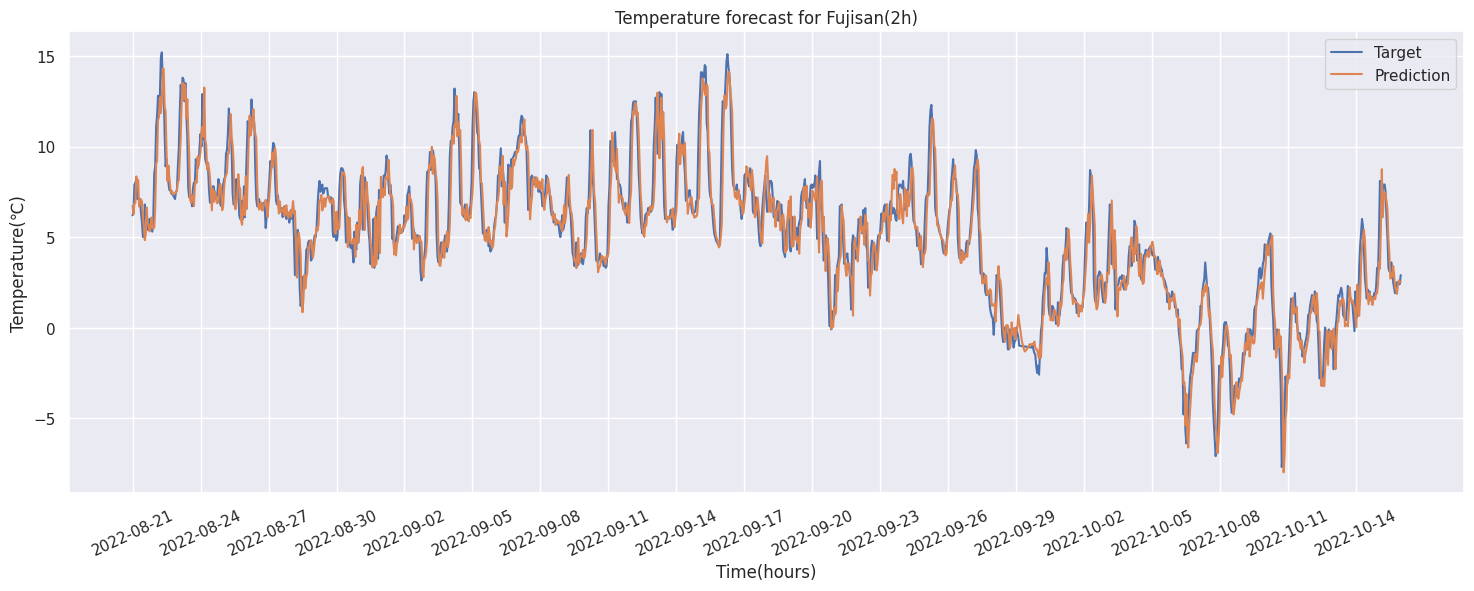

In [ ]:
runner_el.run_val(fixed_params, p='f', h=h) # See the validation results

In [ ]:
# Train on a tuned model, measure time, and calculate evaluation scores

runner_el.run_train_all(fixed_params)
scores = {}
scores['Elastic net'] = [runner_el.best_score, runner_el.t_train]

### LightGBM

In [ ]:
def bayes_objective_lgall(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
            'max_depth': trial.suggest_int('max_depth', 5, 10, step=1)
        }
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_lg = ex.Runner(model.LgbmSL, mf_train_x_all, mf_train_y)
runner_lg.run_opt(bayes_objective_lgall, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2024-01-01 11:52:01,386] A new study created in memory with name: no-name-8be26eec-9287-48fb-bca7-9633a119c5ac
[I 2024-01-01 11:52:08,954] Trial 0 finished with value: 1.1158804002519107 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.1158804002519107.
[I 2024-01-01 11:52:21,360] Trial 1 finished with value: 1.2798223387468803 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.1158804002519107.
[I 2024-01-01 11:52:29,748] Trial 2 finished with value: 1.124754388905874 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.1158804002519107.
[I 2024-01-01 11:52:37,554] Trial 3 finished with value: 1.1389527124421257 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, '

best params {'num_leaves': 31, 'colsample_bytree': 0.75, 'subsample': 0.65, 'min_child_samples': 28, 'max_depth': 7}
best score 1.109


[10]	valid_0's rmse: 4.25575	valid_0's l2: 18.1114
[20]	valid_0's rmse: 1.92117	valid_0's l2: 3.69088
[30]	valid_0's rmse: 1.29062	valid_0's l2: 1.6657
[40]	valid_0's rmse: 1.15423	valid_0's l2: 1.33225
[50]	valid_0's rmse: 1.11758	valid_0's l2: 1.24899
[60]	valid_0's rmse: 1.10337	valid_0's l2: 1.21743
[70]	valid_0's rmse: 1.09828	valid_0's l2: 1.20622
[80]	valid_0's rmse: 1.09657	valid_0's l2: 1.20247
[90]	valid_0's rmse: 1.09536	valid_0's l2: 1.19981
[100]	valid_0's rmse: 1.09423	valid_0's l2: 1.19733
[110]	valid_0's rmse: 1.09308	valid_0's l2: 1.19482
[120]	valid_0's rmse: 1.09363	valid_0's l2: 1.19603


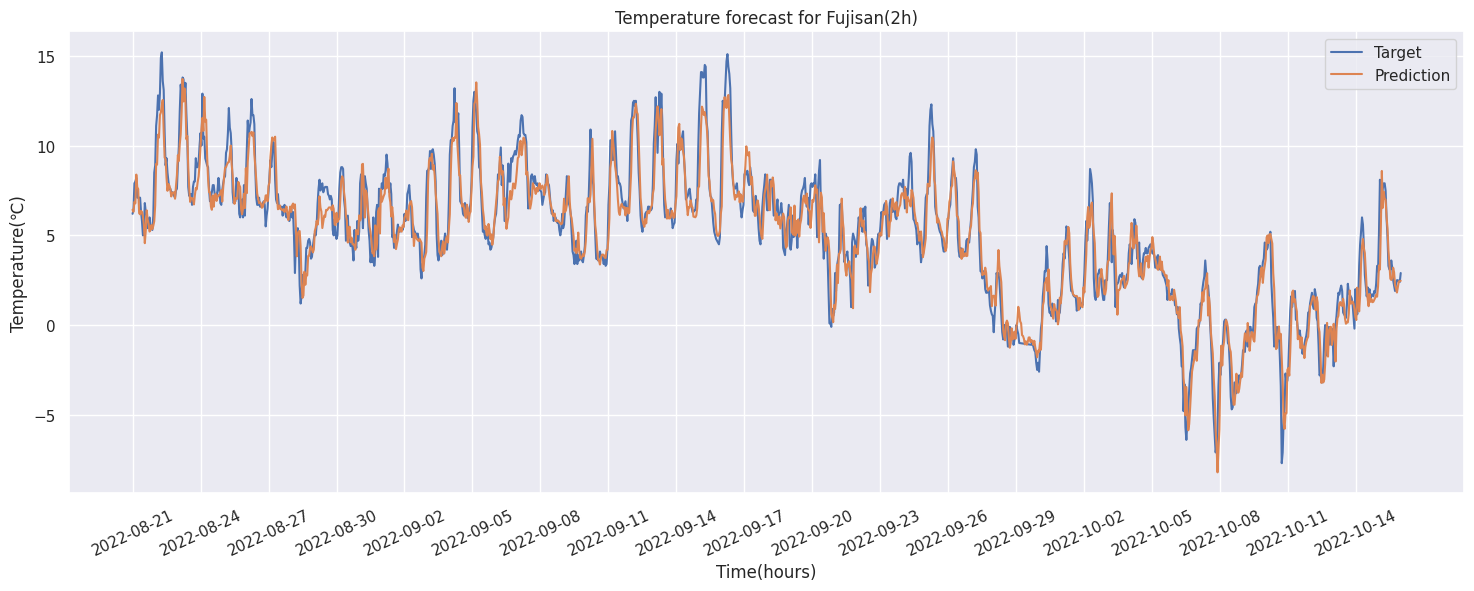

In [ ]:
fixed_params = {'patience' : 15,
                'verbose' : 10,
                'n_estimators' : 10000}

runner_lg.run_val(fixed_params, p='f', h=h)

In [ ]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_lg.run_train_all(fixed_params)
scores['LightGBM'] = [runner_lg.best_score, runner_lg.t_train]

best_iteration 114


### XGBoost

In [ ]:
def bayes_objective_xgboost(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
            'max_depth': trial.suggest_int('max_depth', 3, 9, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.6, 0.95, step=0.05)}
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_xgboost = ex.Runner(model.Xgboost, mf_train_x_all, mf_train_y)
runner_xgboost.run_opt(bayes_objective_xgboost, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2024-01-01 12:04:10,768] A new study created in memory with name: no-name-b7a97caa-7899-4f5e-866b-ef4b72dc7df6
[I 2024-01-01 12:04:20,813] Trial 0 finished with value: 1.2058545311427287 and parameters: {'min_child_weight': 4, 'max_depth': 9, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 0 with value: 1.2058545311427287.
[I 2024-01-01 12:04:25,712] Trial 1 finished with value: 1.1702193059344002 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.6, 'subsample': 0.9}. Best is trial 1 with value: 1.1702193059344002.
[I 2024-01-01 12:04:31,192] Trial 2 finished with value: 1.190397663718528 and parameters: {'min_child_weight': 7, 'max_depth': 7, 'colsample_bytree': 0.6, 'subsample': 0.95}. Best is trial 1 with value: 1.1702193059344002.
[I 2024-01-01 12:04:36,301] Trial 3 finished with value: 1.172105149870237 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.65, 'subsample': 0.65}. Best is trial 1 with value: 1.170219

best params {'min_child_weight': 3, 'max_depth': 4, 'colsample_bytree': 0.95, 'subsample': 0.8}
best score 1.133


[0]	validation_0-rmse:8.11775
[20]	validation_0-rmse:1.14893
[40]	validation_0-rmse:1.13623
[58]	validation_0-rmse:1.13366


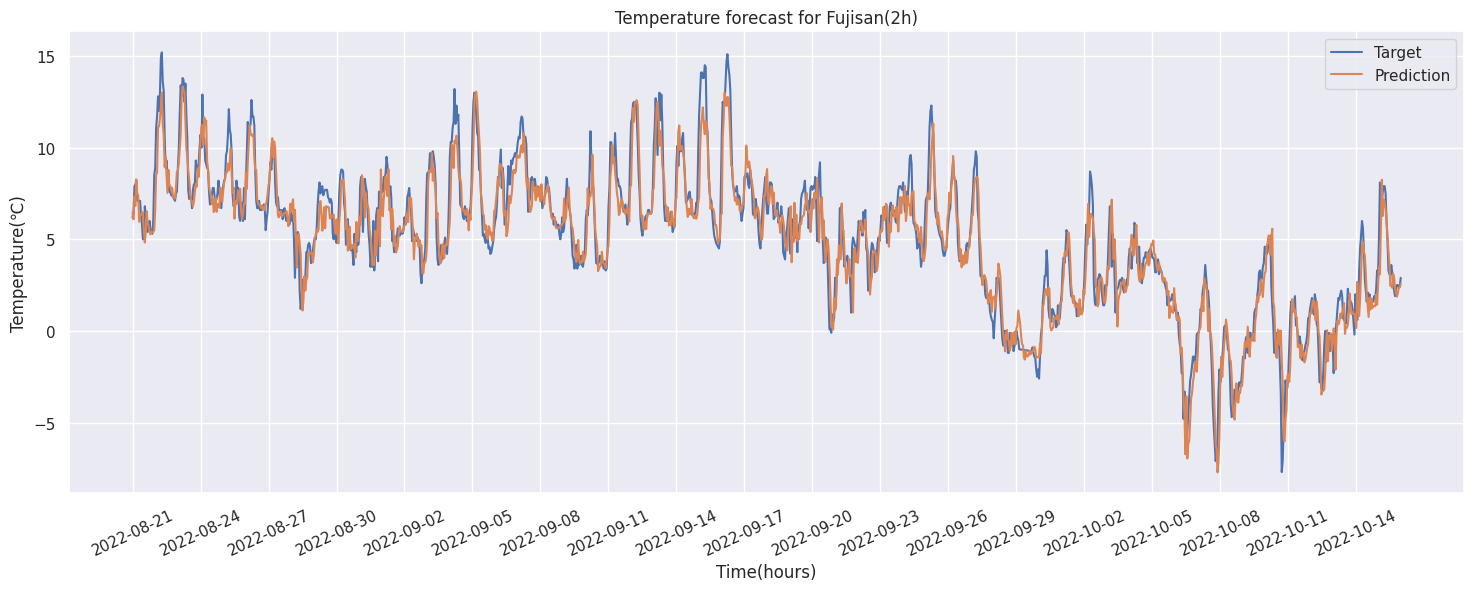

In [ ]:
fixed_params = {'patience' : 15,
                'verbose' : 20,
                'n_estimators' : 10000}

runner_xgboost.run_val(fixed_params, p='f', h=h)

In [ ]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_xgboost.run_train_all(fixed_params)
scores['XGBoost'] = [runner_xgboost.best_score, runner_xgboost.t_train]

best_iteration 43


### ExtraTreesRegressor(Random Forest)

In [ ]:
params = {
    'n_estimators': 100
}

fixed_params = {}
runner_et = ex.Runner(model.ExtraTrees, mf_train_x_all, mf_train_y)
runner_et.hand_opt(params, fixed_params, round_num=3)

params {'n_estimators': 100}
score 1.14


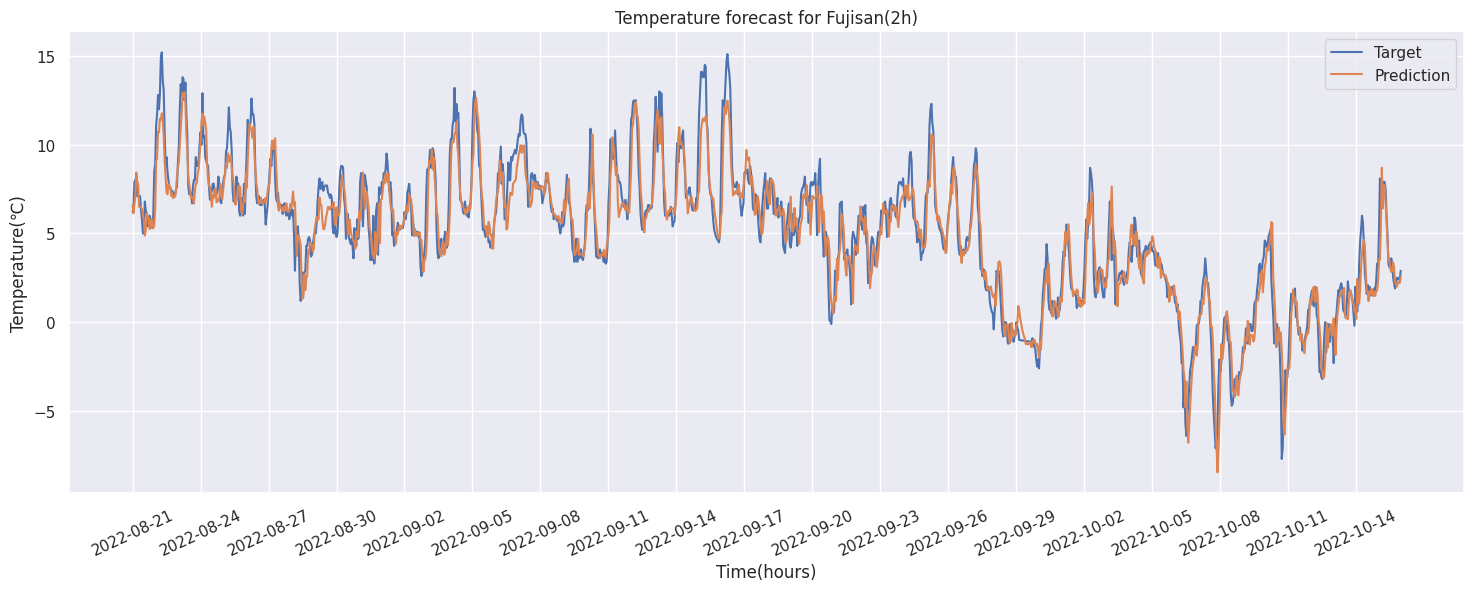

In [ ]:
runner_et.run_val(fixed_params, p='f', h=h)

In [ ]:
runner_et.run_train_all(fixed_params)
scores['Extra trees'] = [runner_et.score, runner_et.t_train]

### Neural Network

In [ ]:
params = {
    'hidden_units1': 1000,
    'hidden_units2': 1000,
    'hidden_units3': 100,
    'hidden_dropout': 0.2
}

fixed_params = {'patience' : 15,
                'verbose' : 1,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}

tf.random.set_seed(42)
runner_nn = ex.Runner(model.MLP, mf_train_x_all, mf_train_y)
runner_nn.hand_opt(params, fixed_params, round_num=3)

Epoch 1/100
314/314 [==============================] - 4s 4ms/step - loss: 8.4667 - rmse: 2.9098 - val_loss: 2.8140 - val_rmse: 1.6775
Epoch 2/100
314/314 [==============================] - 1s 3ms/step - loss: 3.8213 - rmse: 1.9548 - val_loss: 2.1192 - val_rmse: 1.4558
Epoch 3/100
314/314 [==============================] - 1s 3ms/step - loss: 3.2091 - rmse: 1.7914 - val_loss: 1.7677 - val_rmse: 1.3295
Epoch 4/100
314/314 [==============================] - 1s 3ms/step - loss: 2.9963 - rmse: 1.7310 - val_loss: 1.6164 - val_rmse: 1.2714
Epoch 5/100
314/314 [==============================] - 1s 3ms/step - loss: 2.7374 - rmse: 1.6545 - val_loss: 1.7515 - val_rmse: 1.3235
Epoch 6/100
314/314 [==============================] - 1s 3ms/step - loss: 2.6983 - rmse: 1.6426 - val_loss: 1.9169 - val_rmse: 1.3845
Epoch 7/100
314/314 [==============================] - 1s 3ms/step - loss: 2.5421 - rmse: 1.5944 - val_loss: 1.5781 - val_rmse: 1.2562
Epoch 8/100
314/314 [==============================] - 

Epoch 1/100
405/405 [==============================] - 2s 4ms/step - loss: 8.5920 - rmse: 2.9312 - val_loss: 2.9650 - val_rmse: 1.7219
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 3.9567 - rmse: 1.9891 - val_loss: 2.4183 - val_rmse: 1.5551
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 3.4165 - rmse: 1.8484 - val_loss: 2.2169 - val_rmse: 1.4889
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 3.1096 - rmse: 1.7634 - val_loss: 2.0600 - val_rmse: 1.4353
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8605 - rmse: 1.6913 - val_loss: 1.9260 - val_rmse: 1.3878
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 2.7316 - rmse: 1.6528 - val_loss: 1.7464 - val_rmse: 1.3215
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 2.6564 - rmse: 1.6298 - val_loss: 1.7059 - val_rmse: 1.3061
Epoch 8/100
405/405 [==============================] - 

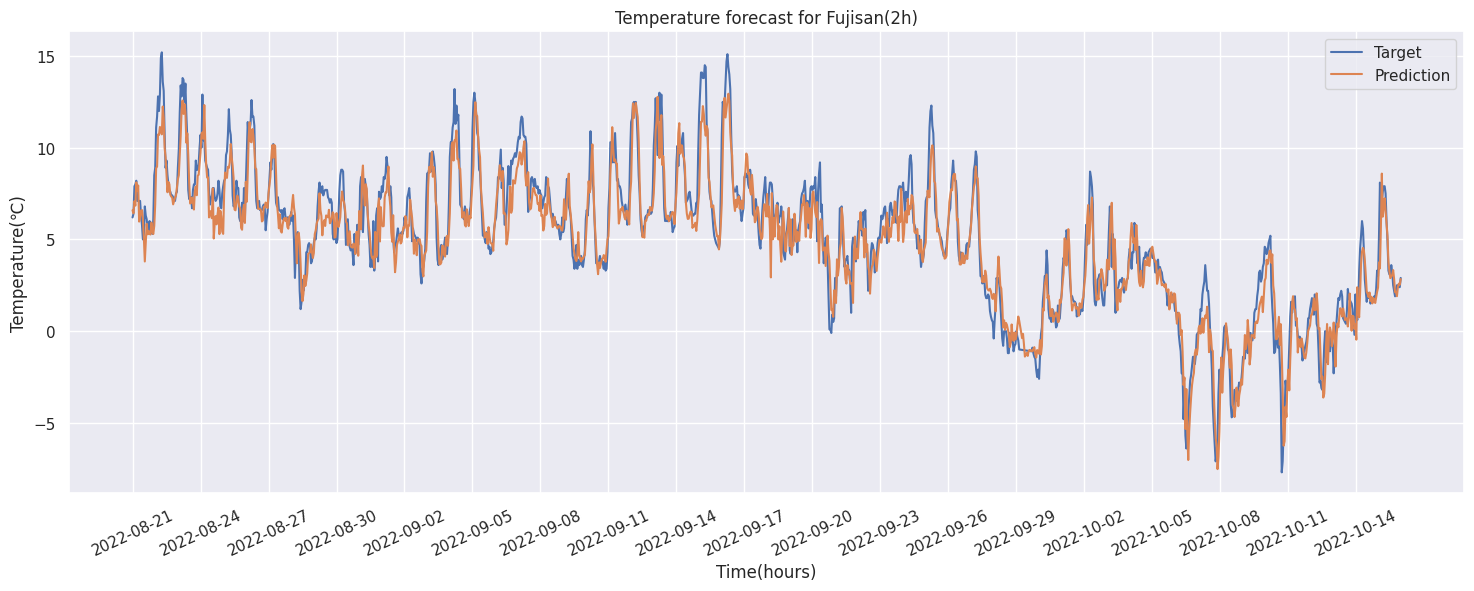

In [ ]:
fixed_params = {'patience' : 15,
                'verbose' : 1,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}

runner_nn.run_val(fixed_params, p='f', h=h)

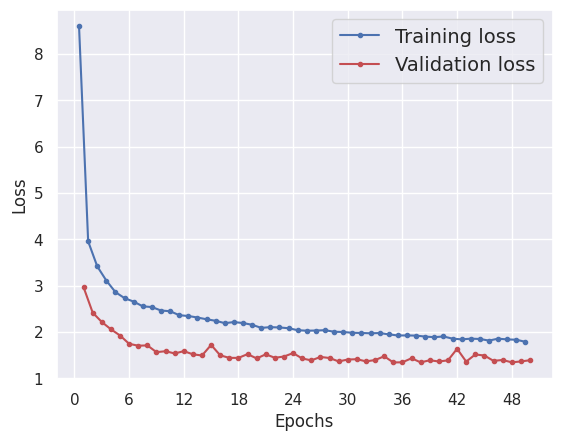

In [ ]:
runner_nn.run_curve()

In [ ]:
fixed_params = {'patience' : False,
                'verbose' : 0,
                'learning_rate' : 0.001,
                'nb_epoch' : True}

runner_nn.run_train_all(fixed_params)
scores['Neural network'] = [runner_nn.score, runner_nn.t_train]

best_iteration 50


### Model Comparison

,Elastic net,LightGBM,XGBoost,Extra trees,Neural network
RMSE,1.178,1.109,1.133,1.140,1.542
Training time(s),1.716,2.598,1.230,83.935,59.407


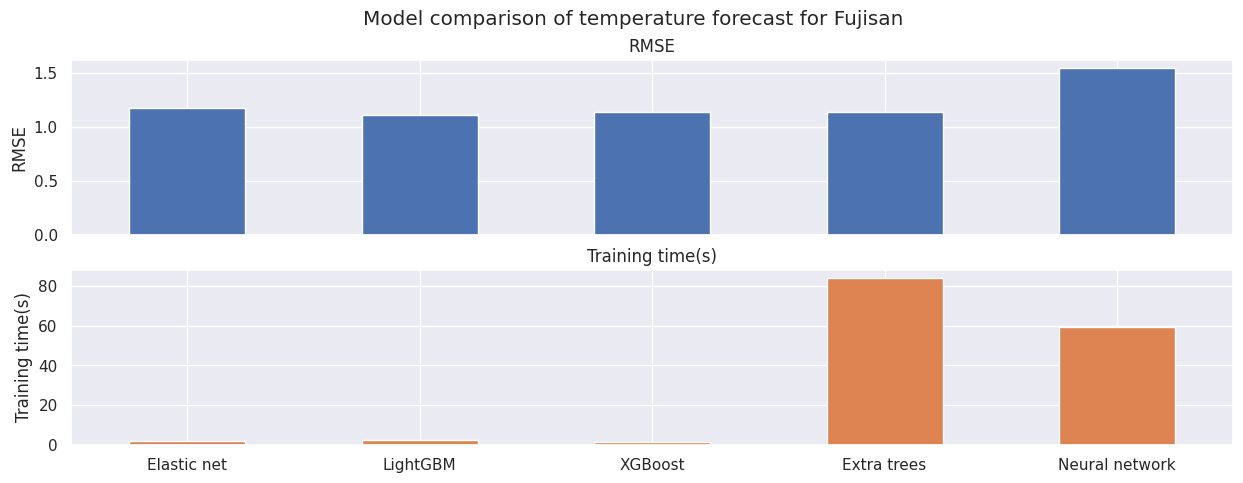

In [ ]:
# Compare the accuracy of the model on the validation data

df_rmse = ex.val_rmse(scores, title='Model comparison of temperature forecast for Fujisan')
df_rmse

## Precipitation prediction for Hakone

In [ ]:
h_train_x_all, h_train_y = md.make_exp_dataset(dataset,md.get_data_hk_2h)
h='(2h)'

'''
h_train_x_all, h_train_y = md.make_exp_dataset(dataset,md.get_data_hk_8h)
h='(8h)'
'''

"\nh_train_x_all, h_train_y = md.make_exp_dataset(dataset,md.get_data_hk_8h)\nh='(8h)'\n"

### Elastic(linear)

In [ ]:
def bayes_objective_el(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'alpha': trial.suggest_float('alpha', 0.0, 1.0, step=0.01),
            'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0, step=0.01),
            'max_iter': trial.suggest_int('max_iter', 100, 1000, step=50)
        }
        val = ex.get_scores(Model=Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params=params)
        return val

    return objective

fixed_params = {'seed' : 42}
runner_el = ex.Runner(model.Elastic, h_train_x_all, h_train_y)
runner_el.run_opt(bayes_objective_el, fixed_params=fixed_params, n_trials=100, seed = 42)

[I 2024-01-01 12:24:36,069] A new study created in memory with name: no-name-f2fef086-19b8-4337-bcc8-1ef8ecd63ebc
[I 2024-01-01 12:24:36,537] Trial 0 finished with value: 1.0660657722011038 and parameters: {'alpha': 0.37, 'l1_ratio': 0.96, 'max_iter': 750}. Best is trial 0 with value: 1.0660657722011038.
[I 2024-01-01 12:24:37,114] Trial 1 finished with value: 1.0831897453150694 and parameters: {'alpha': 0.6, 'l1_ratio': 0.15, 'max_iter': 200}. Best is trial 0 with value: 1.0660657722011038.
[I 2024-01-01 12:24:37,670] Trial 2 finished with value: 1.1085748926953343 and parameters: {'alpha': 0.05, 'l1_ratio': 0.87, 'max_iter': 650}. Best is trial 0 with value: 1.0660657722011038.
[I 2024-01-01 12:24:38,427] Trial 3 finished with value: 1.0925290750037964 and parameters: {'alpha': 0.71, 'l1_ratio': 0.02, 'max_iter': 1000}. Best is trial 0 with value: 1.0660657722011038.
[I 2024-01-01 12:24:38,931] Trial 4 finished with value: 1.083009572159507 and parameters: {'alpha': 0.84, 'l1_ratio':

best params {'alpha': 0.47000000000000003, 'l1_ratio': 0.91, 'max_iter': 900}
best score 1.063


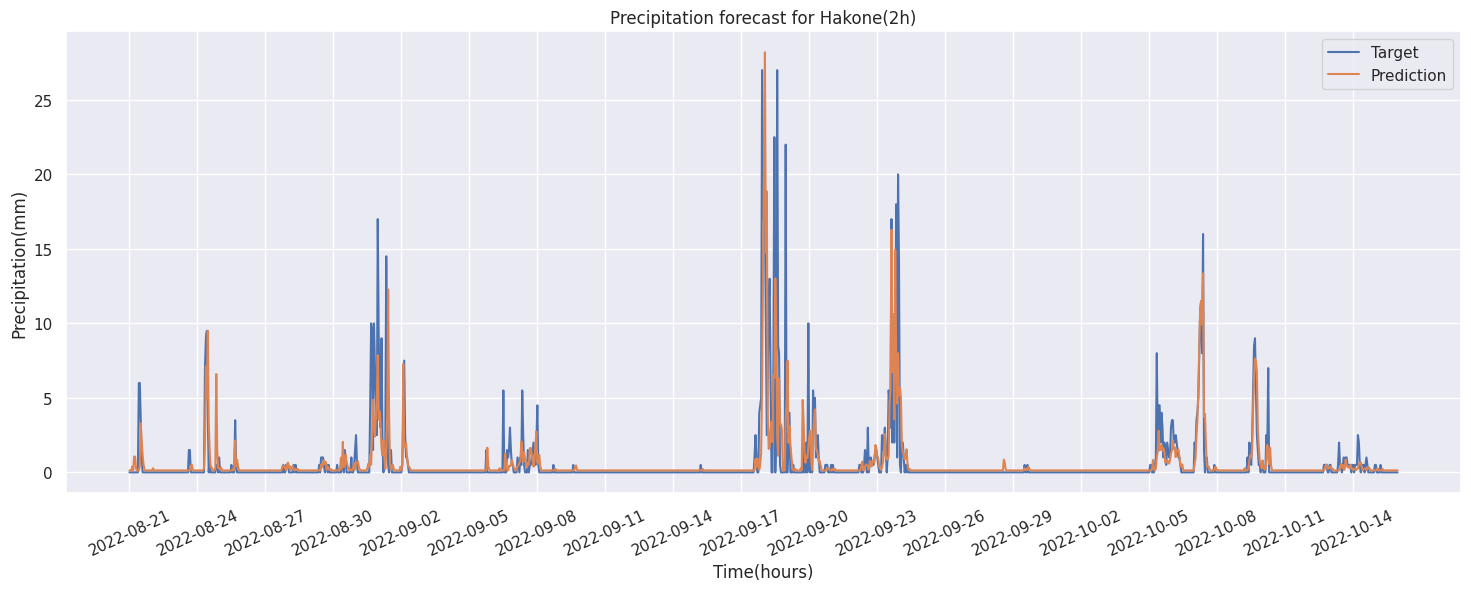

In [ ]:
runner_el.run_val(fixed_params, p='h', h=h)

In [ ]:
runner_el.run_train_all(fixed_params)
scores = {}
scores['Elastic net'] = [runner_el.best_score, runner_el.t_train]

### LightGBM

In [ ]:
def bayes_objective_lgall(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
            'max_depth': trial.suggest_int('max_depth', 5, 10, step=1)
        }
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_lg = ex.Runner(model.LgbmSL, h_train_x_all, h_train_y)
runner_lg.run_opt(bayes_objective_lgall, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2024-01-01 12:25:29,293] A new study created in memory with name: no-name-2f9fa6fc-6632-4ace-8bc8-c8880ee977de
[I 2024-01-01 12:25:32,141] Trial 0 finished with value: 0.9809944111828287 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 0.9809944111828287.
[I 2024-01-01 12:25:35,015] Trial 1 finished with value: 1.1064027753608878 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 0.9809944111828287.
[I 2024-01-01 12:25:37,692] Trial 2 finished with value: 0.9896759844599435 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 0.9809944111828287.
[I 2024-01-01 12:25:41,444] Trial 3 finished with value: 1.009629097071733 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, '

best params {'num_leaves': 7, 'colsample_bytree': 0.75, 'subsample': 0.6, 'min_child_samples': 23, 'max_depth': 10}
best score 0.951


[10]	valid_0's rmse: 1.7611	valid_0's l2: 3.10149
[20]	valid_0's rmse: 1.62046	valid_0's l2: 2.62588
[30]	valid_0's rmse: 1.6097	valid_0's l2: 2.59114
[40]	valid_0's rmse: 1.6246	valid_0's l2: 2.63933


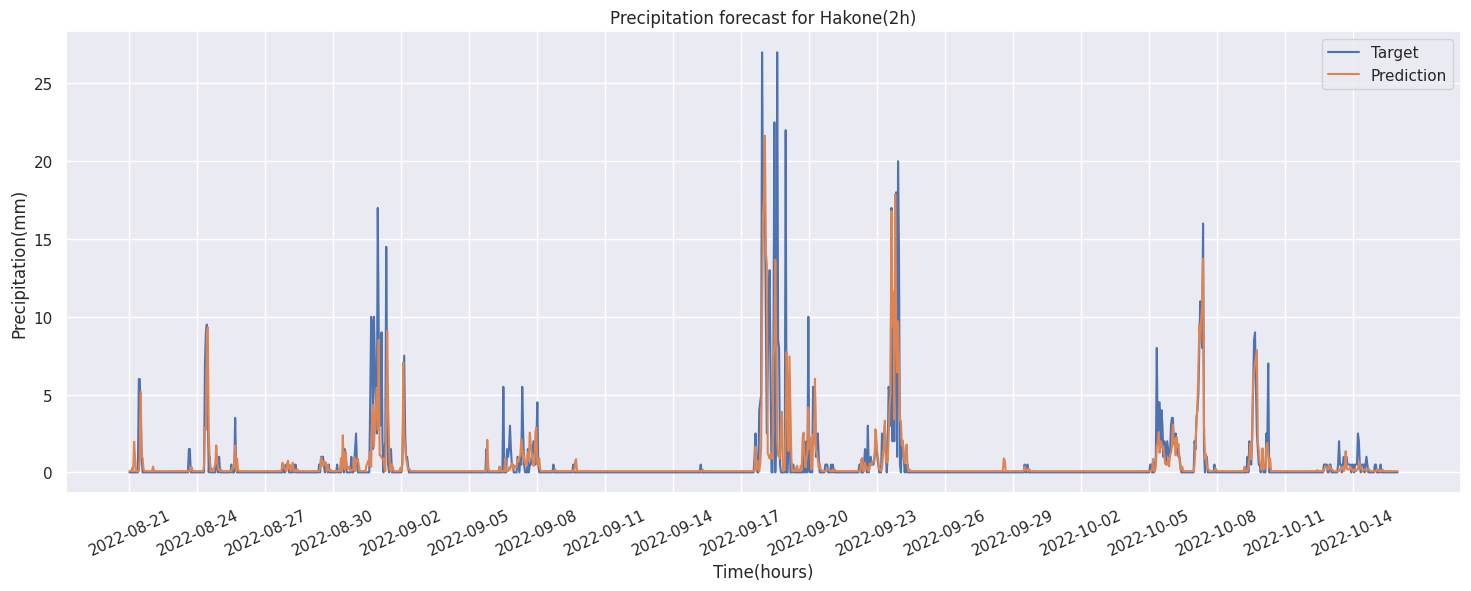

In [ ]:
fixed_params = {'patience' : 15,
                'verbose' : 10,
                'n_estimators' : 10000}

runner_lg.run_val(fixed_params, p='h', h=h)

In [ ]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_lg.run_train_all(fixed_params)
scores['LightGBM'] = [runner_lg.best_score, runner_lg.t_train]

best_iteration 27


### XGBoost

In [ ]:
def bayes_objective_xgboost(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
            'max_depth': trial.suggest_int('max_depth', 3, 9, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.6, 0.95, step=0.05)}
        val = ex.get_scores(Model = Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val

    return objective

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_xgboost = ex.Runner(model.Xgboost, h_train_x_all, h_train_y)
runner_xgboost.run_opt(bayes_objective_xgboost, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2024-01-01 12:30:17,538] A new study created in memory with name: no-name-66d3d4a6-2746-4471-9014-6e723e67c9de
[I 2024-01-01 12:30:22,749] Trial 0 finished with value: 1.0155363413703498 and parameters: {'min_child_weight': 4, 'max_depth': 9, 'colsample_bytree': 0.85, 'subsample': 0.8}. Best is trial 0 with value: 1.0155363413703498.
[I 2024-01-01 12:30:25,466] Trial 1 finished with value: 1.0045635095888226 and parameters: {'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.6, 'subsample': 0.9}. Best is trial 1 with value: 1.0045635095888226.
[I 2024-01-01 12:30:28,695] Trial 2 finished with value: 1.0132437113982655 and parameters: {'min_child_weight': 7, 'max_depth': 7, 'colsample_bytree': 0.6, 'subsample': 0.95}. Best is trial 1 with value: 1.0045635095888226.
[I 2024-01-01 12:30:31,306] Trial 3 finished with value: 1.0254091384683874 and parameters: {'min_child_weight': 9, 'max_depth': 4, 'colsample_bytree': 0.65, 'subsample': 0.65}. Best is trial 1 with value: 1.0045

best params {'min_child_weight': 7, 'max_depth': 3, 'colsample_bytree': 0.85, 'subsample': 0.75}
best score 0.971


[0]	validation_0-rmse:2.07184
[20]	validation_0-rmse:1.62266
[39]	validation_0-rmse:1.62652


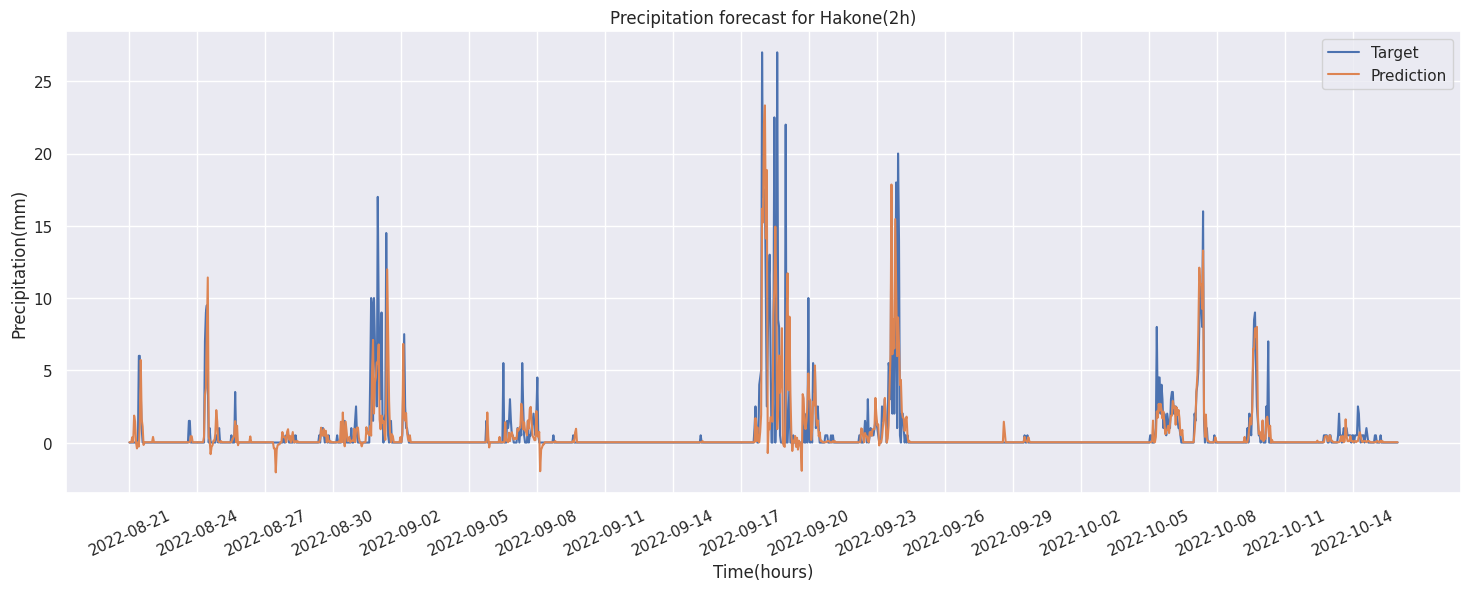

In [ ]:
fixed_params = {'patience' : 15,
                'verbose' : 20,
                'n_estimators' : 10000}

runner_xgboost.run_val(fixed_params, p='h', h=h)

In [ ]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True}

runner_xgboost.run_train_all(fixed_params)
scores['XGBoost'] = [runner_xgboost.best_score, runner_xgboost.t_train]

best_iteration 24


### ExtraTreesRegressor(Random Forest)

In [ ]:
params = {
    'n_estimators': 100
}

fixed_params = {}
runner_et = ex.Runner(model.ExtraTrees, h_train_x_all, h_train_y)
runner_et.hand_opt(params, fixed_params, round_num=3)

params {'n_estimators': 100}
score 1.024


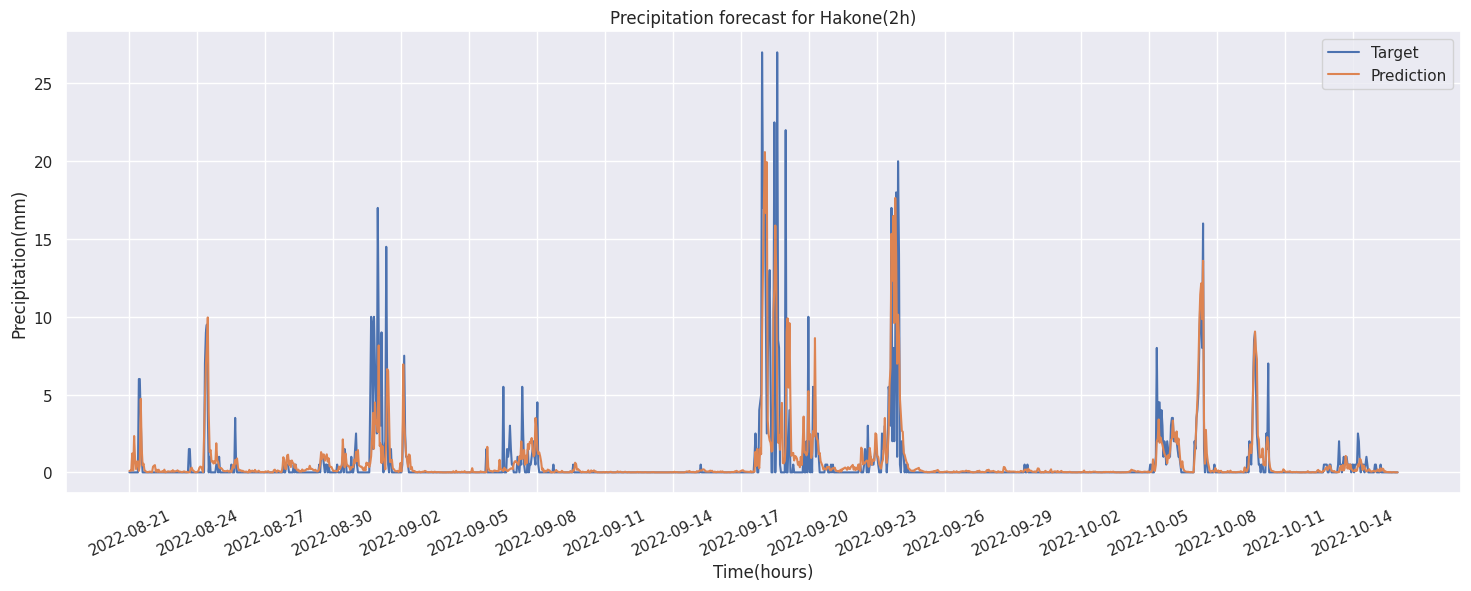

In [ ]:
runner_et.run_val(fixed_params, p='h', h=h)

In [ ]:
runner_et.run_train_all(fixed_params)
scores['Extra trees'] = [runner_et.score, runner_et.t_train]

### Neural Network

In [ ]:
params = {
    'hidden_units1': 1000,
    'hidden_units2': 1000,
    'hidden_units3': 100,
    'hidden_dropout': 0.2
}

fixed_params = {'patience' : 15,
                'verbose' : 0,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}

tf.random.set_seed(42)
runner_nn = ex.Runner(model.MLP, h_train_x_all, h_train_y)
runner_nn.hand_opt(params, fixed_params, round_num=3)

92/92 [==============================] - 0s 1ms/step
params {'hidden_units1': 1000, 'hidden_units2': 1000, 'hidden_units3': 100, 'hidden_dropout': 0.2}
score 0.997


Epoch 1/100
405/405 [==============================] - 2s 4ms/step - loss: 3.0368 - rmse: 1.7427 - val_loss: 3.6832 - val_rmse: 1.9192
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 2.1146 - rmse: 1.4542 - val_loss: 3.3080 - val_rmse: 1.8188
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 1.8598 - rmse: 1.3637 - val_loss: 3.3816 - val_rmse: 1.8389
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 1.8011 - rmse: 1.3421 - val_loss: 3.3661 - val_rmse: 1.8347
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6493 - rmse: 1.2842 - val_loss: 4.0969 - val_rmse: 2.0241
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 1.5512 - rmse: 1.2455 - val_loss: 3.4201 - val_rmse: 1.8494
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 1.7017 - rmse: 1.3045 - val_loss: 3.4605 - val_rmse: 1.8602
Epoch 8/100
405/405 [==============================] - 

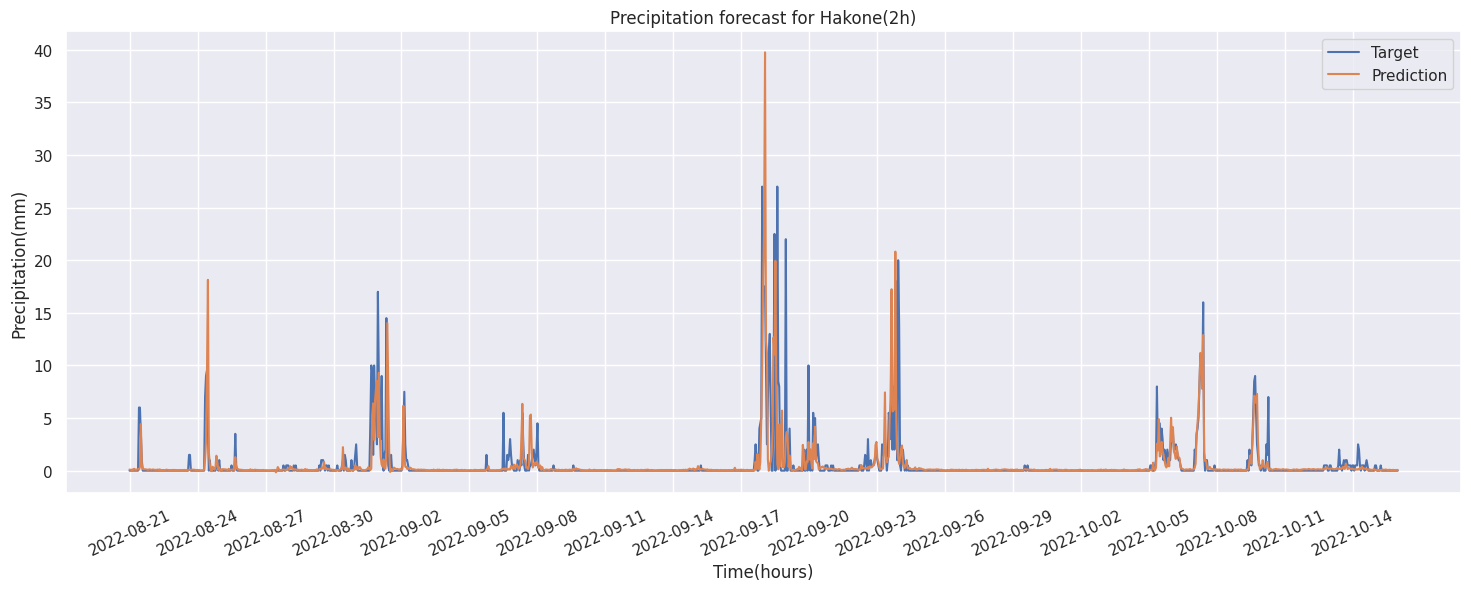

In [ ]:
fixed_params = {'patience' : 15,
                'verbose' : 1,
                'learning_rate' : 0.001,
                'nb_epoch' : 100}


runner_nn.run_val(fixed_params, p='h', h=h)

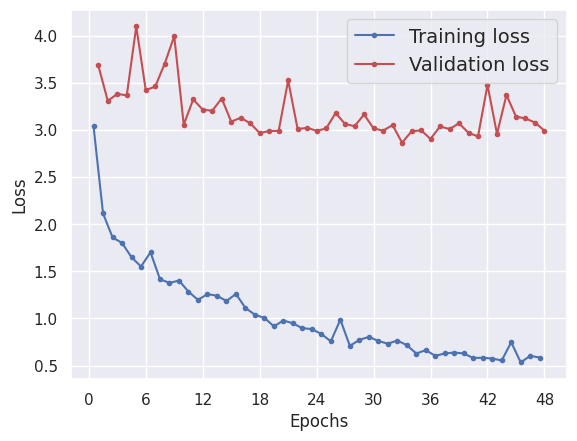

In [ ]:
runner_nn.run_curve()

In [ ]:
fixed_params = {'patience' : False,
                'verbose' : 0,
                'learning_rate' : 0.001,
                'nb_epoch' : True}

runner_nn.run_train_all(fixed_params)
scores['Neural network'] = [runner_nn.score, runner_nn.t_train]

best_iteration 48


### Model Comparison

,Elastic net,LightGBM,XGBoost,Extra trees,Neural network
RMSE,1.063,0.951,0.971,1.024,0.997
Training time(s),0.132,0.899,0.802,77.121,57.571


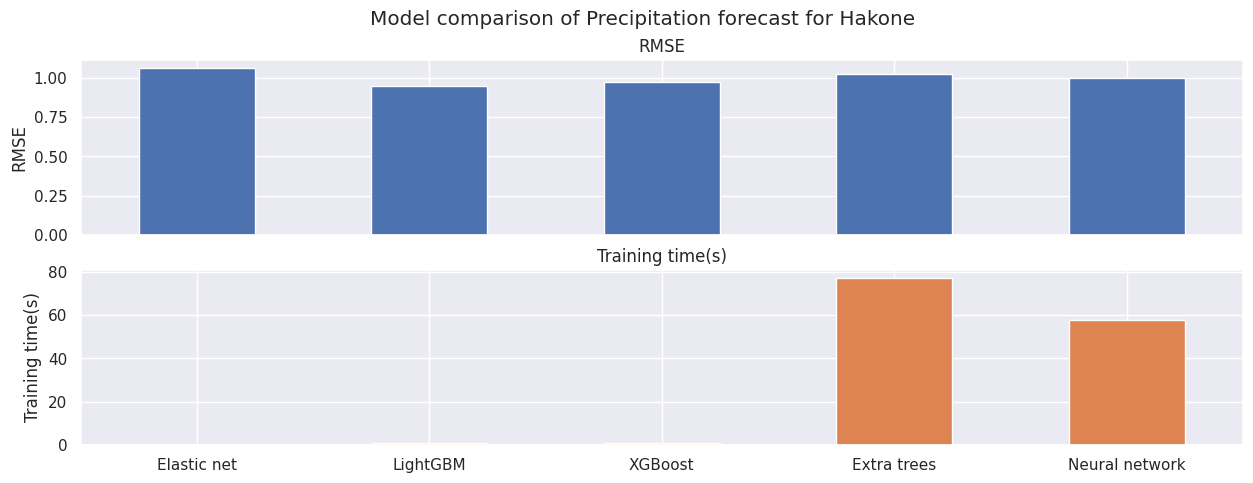

In [ ]:
df_rmse = ex.val_rmse(scores, title='Model comparison of Precipitation forecast for Hakone')
df_rmse